## Make a prediction about the coal production

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
sns.set();


# 1.0 Load Data 
Date Source: http://www.eia.gov/coal/data.php#production

In [186]:
#Set index to MSHA ID
df=pd.read_csv('../data/cleaned_coalpublic2015.csv', index_col='MSHA ID')
df.head()

,Year,Mine_Name,Mine_State,Mine_County,Mine_Status,Mine_Type,Company_Type,Operation_Type,Operating_Company,Operating_Company_Address,Union_Code,Coal_Supply_Region,Production_(short_tons),Average_Employees,Labor_Hours,log_production
MSHA ID,,,,,,,,,,,,,,,,
103381,2015,Jesse Creek H.W.M.,Alabama,Bibb,Active,Surface,Independent Producer Operator,Mine only,"Jesse Creek Mining,llc","1615 Kent Dairy Rd, Alabaster, AL 35007",NaN,Appalachia Southern,62598,6,13713,11.044489
103246,2015,Bear Creek,Alabama,Franklin,Temporarily closed,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","912 Edenton Street, Birmingham, AL 35242",NaN,Appalachia Southern,25481,9,17641,10.145688
103451,2015,Knight Mine,Alabama,Franklin,Temporarily closed,Surface,Independent Producer Operator,Mine only,"Birmingham Coal & Coke Co., In","P.O. Box 354, Lynn, AL 35242",NaN,Appalachia Southern,121474,21,51729,11.707456
102933,2015,Mine No 2,Alabama,Jackson,Temporarily closed,Surface,Independent Producer Operator,Mine only,"Alabama Carbon, Llc","5957 Windswept Blvd, Wise, VA 24293",NaN,Appalachia Southern,3939,5,5287,8.278682
100627,2015,Flat Top Mine,Alabama,Jefferson,Active,Surface,Independent Producer Operator,Mine only,"Cedar Lake Mining, Inc","7802 Highway 78, Cordova, AL 35550",NaN,Appalachia Southern,256521,37,103971,12.454966


In [187]:
len(df)

853

In [188]:
#create a new column "log_production" 
df["log_production"]= np.log(df['Production_(short_tons)'])

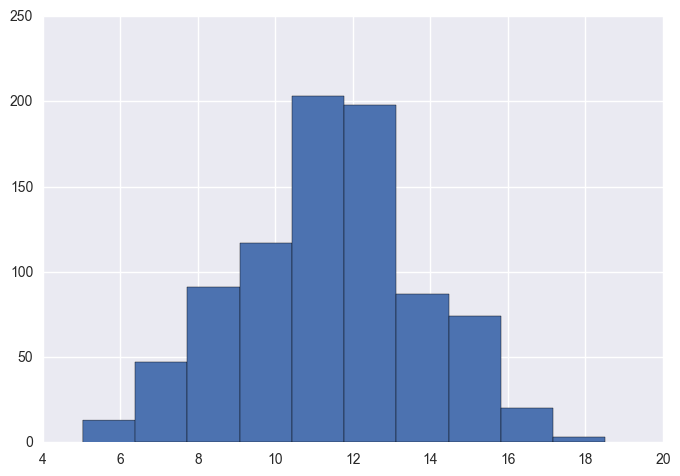

In [189]:
df.log_production.hist()

In [190]:
#May be predictive variable: A good predictor in how productive the mine is.
df.Mine_Status.unique()

array(['Active', 'Temporarily closed', 'Permanently abandoned',
       'Active, men working, not producing'], dtype=object)

In [191]:
#
df[['Mine_Status','Production_(short_tons)']].groupby('Mine_Status').mean()


,Production_(short_tons)
Mine_Status,
Active,1.588046e+06
"Active, men working, not producing",2.834705e+05
Permanently abandoned,5.949539e+04
Temporarily closed,5.024980e+04


In [192]:
#
df[['Mine_Status','log_production']].groupby('Mine_Status').mean()

,log_production
Mine_Status,
Active,11.979012
"Active, men working, not producing",11.289035
Permanently abandoned,10.120947
Temporarily closed,9.203329


## Predict the production of coal mines in 2015
What caused high or lower production

### Feature Engineering

In [193]:
for columns in df:
    print columns

Year
Mine_Name
Mine_State
Mine_County
Mine_Status
Mine_Type
Company_Type
Operation_Type
Operating_Company
Operating_Company_Address
Union_Code
Coal_Supply_Region
Production_(short_tons)
Average_Employees
Labor_Hours
log_production


In [194]:
df.Union_Code.unique()

array([nan, 'United Mine Workers Of America',
       'International Brotherhood Of Teamsters, Chauffeurs, Warehouse',
       'International Union Of Operation Engineers',
       'International Brotherhood Of Electrical Workers',
       'Western Energy Workers'], dtype=object)

Of the above features on two are number: labour hours and Average_employee--Split into numerical features; and categorical variables

In [195]:
features =["Average_Employees",
            "Labor_Hours" ,
              ]

categoricals = ['Mine_State',
               'Mine_County',
               'Mine_Status',
               'Mine_Type',
               "Company_Type",
               "Operation_Type",
               "Union_Code",
               "Coal_Supply_Region",
                      ]
           
df.target = ['log_production'] 

### What is the relationship between Mine_Status and log_production?

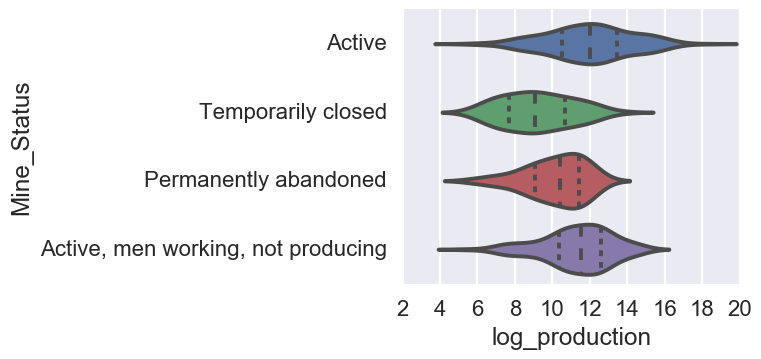

In [196]:
#fig = plt.sublots(figsize = (14,8))
plt.figure(figsize=(8,4))
sns.set_context('poster')
sns.violinplot(y="Mine_Status", x = "log_production", data=df,
              inplace =True, inner ="quartile")
plt.tight_layout()

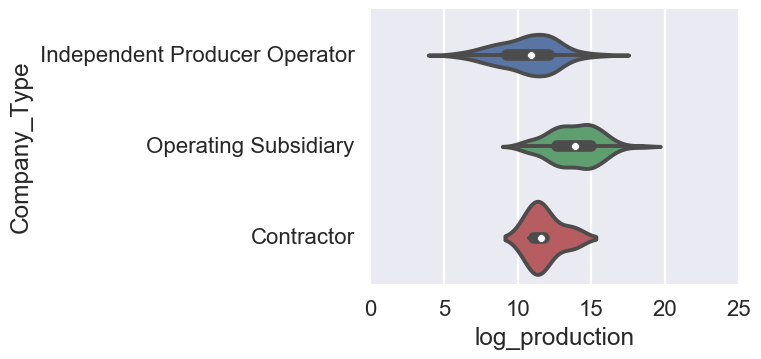

In [197]:
plt.figure(figsize=(8,4))
sns.set_context('poster')
sns.violinplot(y="Company_Type", x = "log_production", data=df,
              inplace =True, inner ="box", )
plt.tight_layout()

In [198]:
pd.get_dummies(df["Company_Type"]).sample(50).head()

,Contractor,Independent Producer Operator,Operating Subsidiary
MSHA ID,,,
4102776,0,1,0
3607443,0,1,0
4003441,0,1,0
4407288,0,1,0
4606213,0,1,0


In [199]:
#convert cetegorical varables into dummy numeric variables
dummy_categoricals = []
for categorical in categoricals:
    print categorical, len(df[categorical].unique())
    # Avoid the dummy trap variable
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    #concanate
    df = pd.concat([df, temp_df],axis =1)
    temp_df.drop("_".join([categorical,str(drop_var)]), axis =1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

Mine_State 29
Mine_County 151
Mine_Status 4
Mine_Type 3
Company_Type 3
Operation_Type 2
Union_Code 6
Coal_Supply_Region 9


In [200]:
dummy_categoricals[:10]

['Mine_State_Alabama',
 'Mine_State_Alaska',
 'Mine_State_Arizona',
 'Mine_State_Arkansas',
 'Mine_State_Colorado',
 'Mine_State_Illinois',
 'Mine_State_Indiana',
 'Mine_State_Kansas',
 'Mine_State_Kentucky (East)',
 'Mine_State_Kentucky (West)']

## Build our Model

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [202]:
len(dummy_categoricals)

197

In [203]:
train, test = train_test_split(df, test_size=0.3, random_state=0)

In [204]:
model = RandomForestRegressor(n_estimators=100, oob_score=True)
model.fit(train[features + dummy_categoricals],train[target])

/Users/shirojean/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

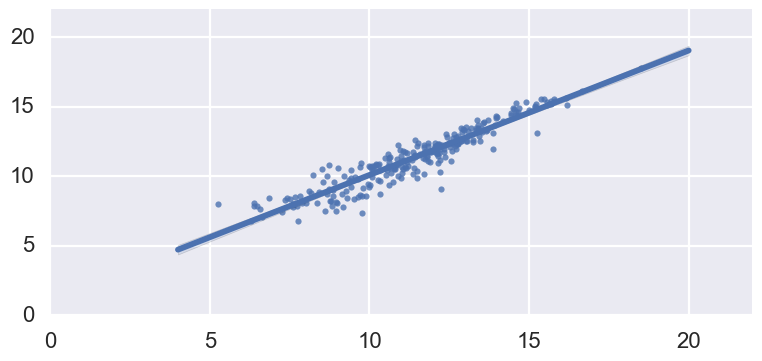

In [211]:
plt.figure(figsize=(8,4))
sns.regplot(test[target], model.predict(test[features + dummy_categoricals]))
plt.xlim(0,22)
plt.ylim(0,22)
plt.tight_layout()

## Model evaluatuion: Regression metrics

The sklearn.metrics module implements several loss, score, and utility functions to measure regression performance. Some of those have been enhanced to handle the multioutput case: 
* mean_squared_error, 
* mean_absolute_error, 
* explained_variance_score and 
* r2_score.

In [220]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score,mean_absolute_error
predicted = model.predict(test[features + dummy_categoricals])
r2_score(test[target],predicted)

0.88681615295425809

In [216]:
mean_absolute_error(test[target], predicted)

0.57202475681832476

In [217]:
mean_squared_error(test[target], predicted)

0.58432817801084624

In [221]:
explained_variance_score(test[target], predicted)

0.88729200912854911

In [228]:
rf_importance =pd.DataFrame({'name':train[features+dummy_categoricals].columns,
                            'importance':model.feature_importances_
                            }).sort_values(by='importance', ascending =False).reset_index(drop=True)
rf_importance.head(20)

,importance,name
0,0.791412,Labor_Hours
1,0.119475,Average_Employees
2,0.009215,Coal_Supply_Region_Powder River Basin
3,0.005724,Mine_Type_Surface
4,0.004157,Mine_Status_Active
5,0.003393,Mine_County_Greene
6,0.002612,Coal_Supply_Region_Illinois Basin
7,0.002412,Coal_Supply_Region_Appalachia Central
8,0.002336,Operation_Type_Mine and Preparation Plant
9,0.002211,Mine_County_Somerset
